In [48]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib import rcParams
import sympy as sy
import scipy.constants as pc
from sympy import *
from math import log10, floor

rcParams['font.size'] = 16
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

In [49]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)
            
    
def txtToArr(name):
    with open(name) as f:
        l = f.readlines()
    
    del l[0]

    time_arr = np.array([])
    temp_arr = np.array([])

    for el in l:
        el_changed = l[l.index(el)].replace(',', '.') 
        l[l.index(el)] = el_changed.split()
        el_changed = el_changed.split()
        time_arr = np.append(time_arr, float(el_changed[0]))
        temp_arr = np.append(temp_arr, float(el_changed[1]))
    
    return time_arr, temp_arr

In [ ]:
# Standard plotting

fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

#ax.plot(x, y, color='b', label='label')
#ax.scatter(x, y, color='r', label='label')
#ax.errorbar(am_x, am_y, xerr=std_x, yerr=std_y, fmt='D', color='#d0740b', label='label')

ax.set(xlabel='x', ylabel='y', title='Titel')
ax.legend()
ax.grid()

#fig.savefig("test.png")

In [ ]:
# Erinnerungen
# x = np.array([,])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

103.74098360655738
0.16488739408384545
-17.93387096774193
0.07668238381297279


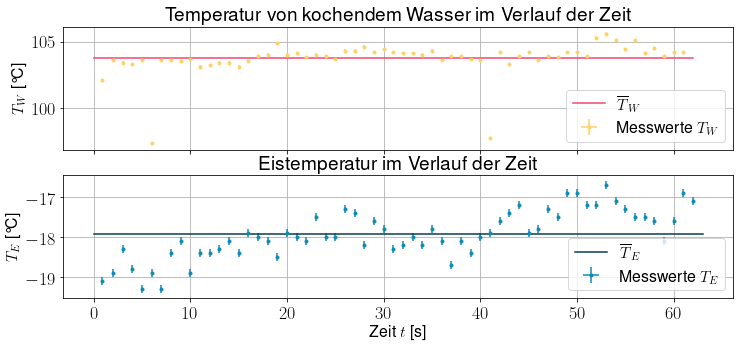

In [103]:
# KALIBRIERDATEN
temp_f = 0.1
time_f = 0.01

time_w_k, temp_w_k  = txtToArr('kochend.txt')
time_e_k, temp_e_k  = txtToArr('Eis.txt')


fig, (ax0, ax1) = plt.subplots(2, figsize=(12,5), sharex=True) 
ax0.tick_params(axis='both', which='major', labelsize=18)
ax0.tick_params(axis='both', which='minor', labelsize=16)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=16)

ax0.errorbar(time_w_k, temp_w_k, xerr=time_f, yerr=temp_f, fmt='.', color='#ffd166', label=r'Messwerte $T_W$')

x_w = np.linspace(0, max(time_w_k)+1, 100)
y_w = np.full( shape=100, fill_value=am(temp_w_k))
ax0.plot(x_w, y_w, color='#ef476f', label='$\overline{T}_W$')


ax0.set(xlabel=r'', ylabel=r'$T_W$ [°C]', title=r'Temperatur von kochendem Wasser im Verlauf der Zeit')
ax0.legend()
ax0.grid()

ax1.errorbar(time_e_k, temp_e_k, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label=r'Messwerte $T_E$')

x_e = np.linspace(0, max(time_e_k)+1, 100)
y_e = np.full( shape=100, fill_value=am(temp_e_k))
ax1.plot(x_e, y_e, color='#073b4c', label='$\overline{T}_E$')


ax1.set(xlabel=r'Zeit $t$ [s]', ylabel=r'$T_E$ [°C]', title=r'Eistemperatur im Verlauf der Zeit')
ax1.legend()
ax1.grid()

fig.savefig("kal.svg")

print(am(temp_w_k))
print(stu(temp_w_k))
print(am(temp_e_k))
print(stu(temp_e_k))

25.583870967741937
0.06613902750428506


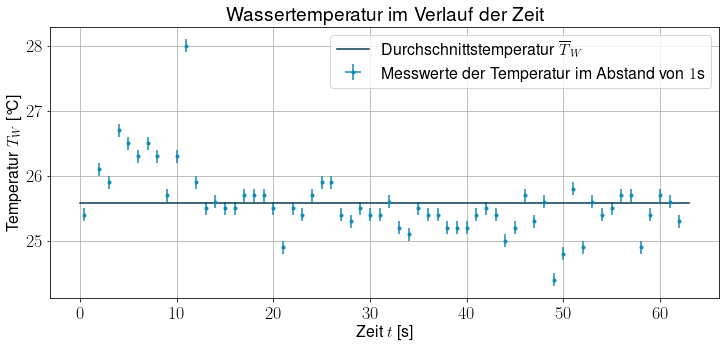

In [87]:

time_w_1, temp_w_1  = txtToArr('6.2_Wasser1.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_w_1, temp_w_1, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $1$s')

x_1 = np.linspace(0, max(time_w_1)+1, 100)
y_1 = np.full( shape=100, fill_value=am(temp_w_1))
ax.plot(x_1, y_1, color='#073b4c', label='Durchschnittstemperatur $\overline{T}_W$')

ax.set(xlabel=r'Zeit $t$ [s]', ylabel=r'Temperatur $T_W$ [°C]', title=r'Wassertemperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Wasser_temp_1.svg")

print(am(temp_w_1))
print(stu(temp_w_1))

26.830392156862743
0.04603876076830793


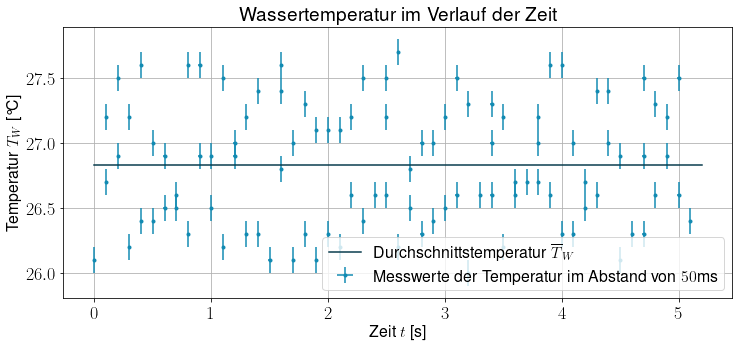

In [88]:
time_w_2, temp_w_2  = txtToArr('6.2_Wasser1_2.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_w_2, temp_w_2, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $50$ms')

x_2 = np.linspace(0, max(time_w_2)+0.1, 100)
y_2 = np.full( shape=100, fill_value=am(temp_w_2))
ax.plot(x_2, y_2, color='#073b4c', label='Durchschnittstemperatur $\overline{T}_W$')

ax.set(xlabel=r'Zeit $t$ [s]', ylabel=r'Temperatur $T_W$ [°C]', title=r'Wassertemperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Wasser_temp_2.svg")

print(am(temp_w_2))
print(stu(temp_w_2))

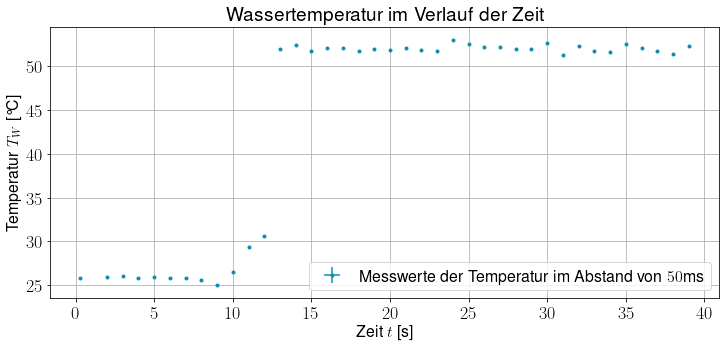

In [89]:
time_er_1, temp_er_1  = txtToArr('6.2_Ergebnis.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_er_1, temp_er_1, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $50$ms')


ax.set(xlabel=r'Zeit $t$ [s]', ylabel=r'Temperatur $T_W$ [°C]', title=r'Wassertemperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Erg_temp_1.svg")

102.6327868852459
0.33235968164957136


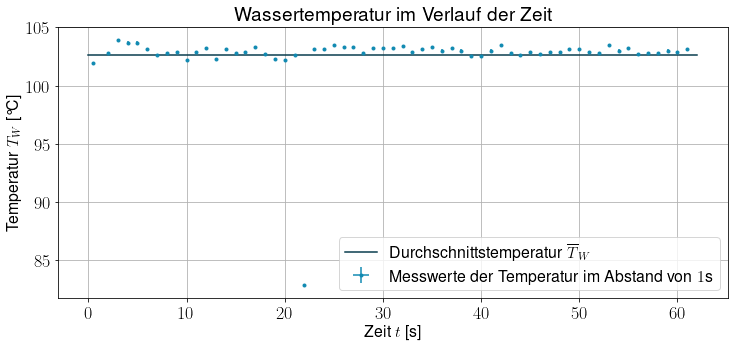

In [94]:
time_w_3, temp_w_3  = txtToArr('6.2_Wasser2.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_w_3, temp_w_3, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $1$s')

x_3 = np.linspace(0, max(time_w_3)+1, 100)
y_3 = np.full( shape=100, fill_value=am(temp_w_3))
ax.plot(x_3, y_3, color='#073b4c', label='Durchschnittstemperatur $\overline{T}_W$')

ax.set(xlabel=r'Zeit $t$ [s]', ylabel=r'Temperatur $T_W$ [°C]', title=r'Wassertemperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Wasser_temp_3.svg")

print(am(temp_w_3))
print(stu(temp_w_3))

96.27999999999999
0.03552741748176538


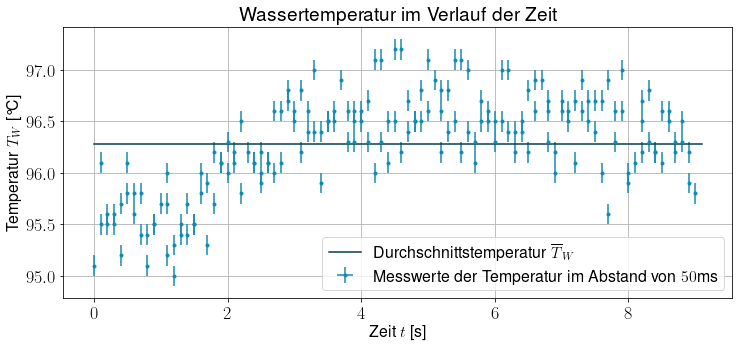

In [93]:
time_w_4, temp_w_4  = txtToArr('6.2_Wasser2_2.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_w_4, temp_w_4, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $50$ms')

x_4 = np.linspace(0, max(time_w_4)+0.1, 100)
y_4 = np.full( shape=100, fill_value=am(temp_w_4))
ax.plot(x_4, y_4, color='#073b4c', label='Durchschnittstemperatur $\overline{T}_W$')

ax.set(xlabel=r'Zeit $t$ [s]', ylabel=r'Temperatur $T_W$ [°C]', title=r'Wassertemperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Wasser_temp_4.svg")

print(am(temp_w_4))
print(stu(temp_w_4))

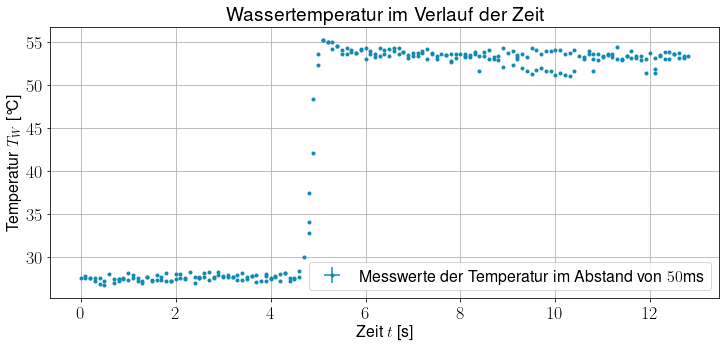

In [92]:
time_er_2, temp_er_2  = txtToArr('6.2_Ergebnis_2.txt')


fig, ax = plt.subplots(figsize=(12,5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.errorbar(time_er_2, temp_er_2, xerr=time_f, yerr=temp_f, fmt='.', color='#118ab2', label='Messwerte der Temperatur im Abstand von $50$ms')


ax.set(xlabel=r'Zeit $t$ [s]', ylabel=r'Temperatur $T_W$ [°C]', title=r'Wassertemperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Erg_temp_w.svg")